## Experimental environment setup

### Library preparation

In [5]:
%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

In [7]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *

In [8]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format

from tqdm import tqdm, tqdm_notebook

In [9]:
import sys 
sys.path.append('../..')
# sys.path.append('..')

from meas_util import *

In [10]:
import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

In [11]:
def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

######################################################################

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

######################################################################

def qcksubplt(ax, dataFM, param_dict, x_label, y_label):
    out = ax.plot(dataFM[x_label], dataFM[y_label], **param_dict)

    ax.set_ylim(pltMaxMin(dataFM[y_label])[0], pltMaxMin(dataFM[y_label])[1])
    ax.set_xlim(pltMaxMin(dataFM[x_label])[0], pltMaxMin(dataFM[x_label])[1])
    ax.set_title('{} ({})'.format(y_label, x_label), size ='large')
    ax.set_ylabel(y_label, fontsize='medium')
    ax.set_xlabel(x_label, fontsize='medium')  

    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 4))
    ax.tick_params(axis='both', labelsize='medium')    
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    return out

######################################################################

def qckplt (fname, showheader = False):
    data = filetoDFM(filename = fname)[0]
    
    plt.close('all')
    plt.rc('font', size=14)
    
    fig, ax_lst = plt.subplots(1, 2, figsize=(9, 4))

    qcksubplt(ax_lst[0], data, {'marker':'.','color':'r'}, 'IS', 'V1')
    ax_lst[0].text(pltMaxMin(data['IS'],pMF=0)[2], pltMaxMin(data['V1'],pMF=1.8)[2], '$T = {}K, \Delta T = {}K$'.format(si_format(data['T8'].mean(), precision =2),si_format(data['T8'].max()-data['T8'].min(), precision =2)), fontsize=12)
    slopeP, interceptP, r_valueP, p_valueP, std_errP = stats.linregress(data['IS'][int(np.floor(data['IS'].size*3/16)):int(np.floor(data['IS'].size*5/16))],data['V1'][int(np.floor(data['V1'].size*3/16)):int(np.floor(data['V1'].size*5/16))])
    slopeN, interceptN, r_valueN, p_valueN, std_errN = stats.linregress(data['IS'][int(np.floor(data['IS'].size*11/16)):int(np.floor(data['IS'].size*13/16))],data['V1'][int(np.floor(data['V1'].size*11/16)):int(np.floor(data['V1'].size*13/16))])
    ax_lst[0].text(pltMaxMin(data['IS'],pMF=0)[2], pltMaxMin(data['V1'],pMF=1.6)[2], '$R_{} = {}\Omega/{}\Omega$'.format('{+/-}',si_format(slopeP, precision =2),si_format(slopeN, precision =2)), fontsize=12)
#     slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(data['IS'],data['V1'])
#     ax_lst[0].text(pltMaxMin(data['IS'],pMF=0)[2], pltMaxMin(data['V1'],pMF=1.4)[2], '$R = {}\Omega$'.format(si_format(slopeA, precision =2)), fontsize=12)
    
    qcksubplt(ax_lst[1], data, {'marker':'.','color':'b'}, 'Time', 'IS')
    
    fig.tight_layout()
    fig.suptitle('file {}'.format(fname.split(r'DC')[1]), x = 0.8, y = 0.02, size = 'x-small')
    fig.subplots_adjust(top=0.8)
    
    plt.show()
    
    if showheader:
        print(filetoDFM(filename = fname)[1])

######################################################################

### Device detail

- ID: Q1D055B1
- Pre-experiment electrical performance
 - <s>N2: (7ba,6ba),</s> $R_{RT, 4pb} = 113k\Omega$, <font color="red">$R_{G, 6a} = 27k\Omega$ >> $131.5k\Omega$ at 8K</font>
 - N4: (3ab,4ba), $R_{RT, 4pb} = 121k\Omega$, $R_{G, 2pb} = 2M\Omega$ >> $14M\Omega$ at 8K
 - <s>N5: (2ab,1ab),</s> $R_{RT, 4pb} = 138k\Omega$, <font color="red">$R_{G, 1b} = 289\Omega$ >> $291\Omega$ at 8K</font>
 - N9: (12ab,11ab), $R_{RT, 4pb} = 94k\Omega$, $R_{G, 2pb} = OVFL$

 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$


- Device scheme
 - Type: 1D chain with 20 SQUIDs
 - Shunting capacitor C0: finger type capacitor, Pt-first.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation:

### Fridge handling log


In [12]:
sampleID = 'D55B1'
# action = 'User: wsLu. Sample: {}. Roughing'.format(sampleID)
# action = 'ON Turbo @P1 = 2.47E-1'
# action = 'ON PT @P1 = 1.99E-3. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 5.41E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 4.04E-1'
# action = 'Start Pulse_PreCool'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [47.9, 4.63, 0.887, 0.032, 0.039]
# Tlst = ['dont care']
flow = '0.29'
stillOut = '10'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

Tue Oct 29 00:31:11 2019
	base T, normal circulation
	T[1,2,5,6,8]:	[47.9, 4.63, 0.887, 0.032, 0.039]
	Flow = 0.29, 	Still = 10%

Mon Oct 28 22:15:51 2019
	base T, ON still 10%
	T[1,2,5,6,8]:	[47.9, 4.73, 0.563, 0.03, 0.037]
	Flow = 0.16, 	Still = 0%

Mon Oct 28 16:43:36 2019
	Start Condense_wLN2
	T[1,2,5,6,8]:	[49.7, 5.42, 5.93, 6.12, 7.0]
	Flow = 0.00, 	Still = 0%

Mon Oct 28 14:45:34 2019
	T[1,2,5,6,8]:	[54, 6.0, 6.6, 6.6, 8.0]
	Flow = 0.00, 	Still = 0%

Mon Oct 28 13:46:36 2019
	T[1,2,5,6,8]:	[58, 6.5, 7.4, 7.8, 8.9]
	Flow = 0.00, 	Still = 0%

Mon Oct 28 11:53:56 2019
    ON PT after all mixtures are collected. OFF still and lines as well.
	T[1,2,5,6,8]:	[122, 37, 36, 15, 25]
	Flow = 0.00, 	Still = 0%

Mon Oct 28 09:49:04 2019
    ON PT to hold T again, but it seems that T6 drops right after PT ON.
    Decided to OFF PT since less than 50% mixture were collected.
	T[1,2,5,6,8]:	[64, 10.5, 9.5, 1.32, 1.32]
	Flow = 0.00, 	Still = 10%

Mon Oct 28 09:35:43 2019
    OFF PT to expedite the collecting process.
	T[1,2,5,6,8]:	[45, 5.6, 4.5, 1.3, 1.3]
	Flow = 0.00, 	Still = 10%

Mon Oct 28 09:06:09 2019
	T8 = 330mK, which suggest that some heat spots exist in the system.
    ON HS-STILL, HS-MC, keep still 10% and warm up to collect mixture.
	T[1,2,5,6,8]:	[48, 4.69, 6.32, 0.38, 0.33]
	Flow = 0.10, 	Still = 10%

Mon Oct 28 07:45:03 2019
    For some reasons the cool down wasn't successful. Double checking. 
    Trying to add still 10% and see how it goes.
	T[1,2,5,6,8]:	[48, 4.69, 1.5, 0.77, 0.33]
	Flow = 0.09, 	Still = 0%

Sun Oct 27 20:51:16 2019
	Start Condense_wLN2
	T[1,2,5,6,8]:	[48, 5.2, 4.1, 6.7, 8.2]
	Flow = 0.00, 	Still = 0%

Sun Oct 27 20:49:36 2019
	Pump coldtrap to P6 = 4.04E-1
	T[1,2,5,6,8]:	[48, 5.2, 4.1, 6.7, 8.2]
	Flow = 0.00, 	Still = 0%

Sun Oct 27 20:43:59 2019
	Test Cyro eff., t1hr @P1 = 5.41E-6
	T[1,2,5,6,8]:	[48, 5.2, 4.1, 6.7, 8.2]
	Flow = 0.00, 	Still = 0%

Sat Oct 26 16:18:21 2019
	ON PT @P1 = 1.99E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	[dont care]
	Flow = 0.00, 	Still = 0%

Sat Oct 26 12:55:05 2019
 	ON Turbo @P1 = 2.47E-1
 	T[1,2,5,6,8]:	[dont care]
	Flow = 0.00, 	Still = 0%

Sat Oct 26 12:20:00 2019
	User: wsLu. Sample: D55B1 revisit. Roughing
	T[1,2,5,6,8]:	[dont care]
	Flow = 0.00, 	Still = 0%


### Biasing scheme

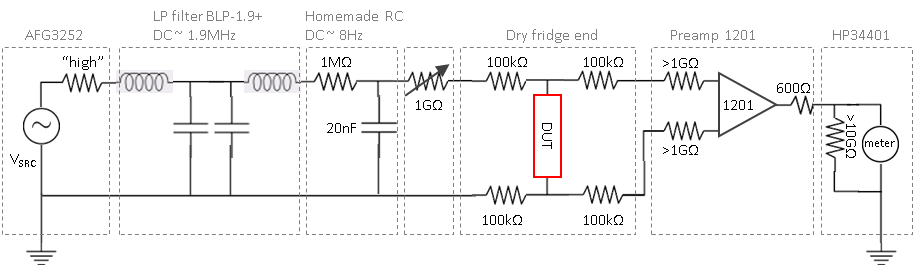

In [13]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

## Data acqusition

### IVc measurement at RT

- Q1D055B1N4_RT, R~125k$\Omega$

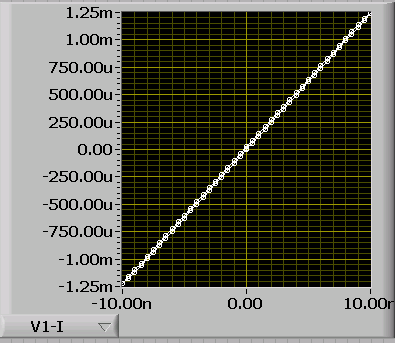

In [14]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\55B1_revist 1D chain\img\191026-184753.png'))

- Measure at intermediat T during cooldown

<IPython.core.display.Javascript object>


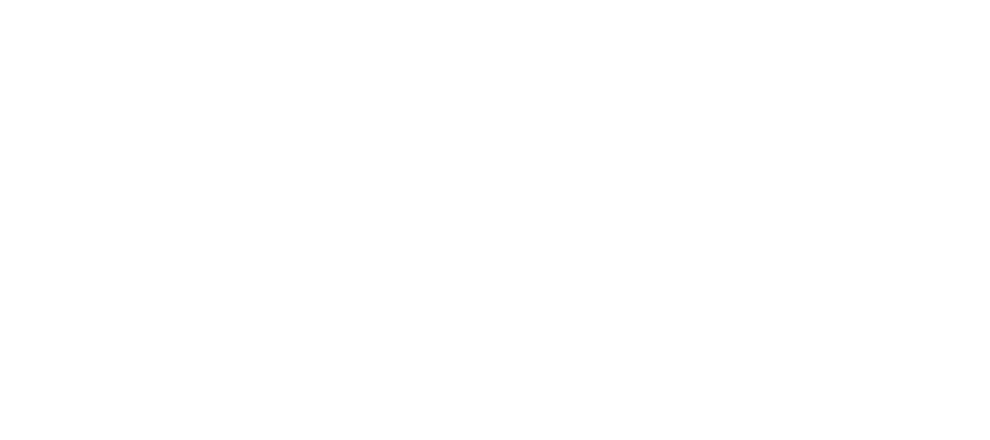

In [15]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191027-Q1D055B1N4_intT-124115.txt') 

<IPython.core.display.Javascript object>


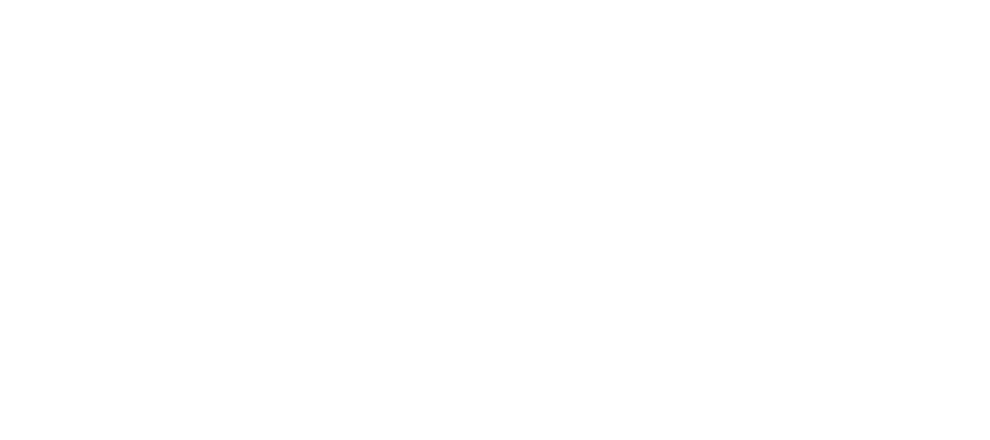

In [16]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191027-Q1D055B1N4_intT-193411.txt')

<IPython.core.display.Javascript object>


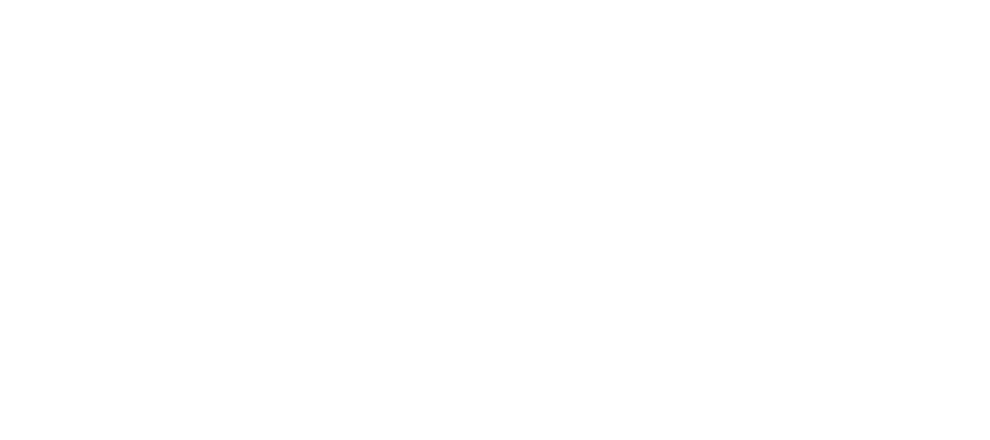

In [17]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191027-55B1N4_IV8K-204549.txt')

<IPython.core.display.Javascript object>


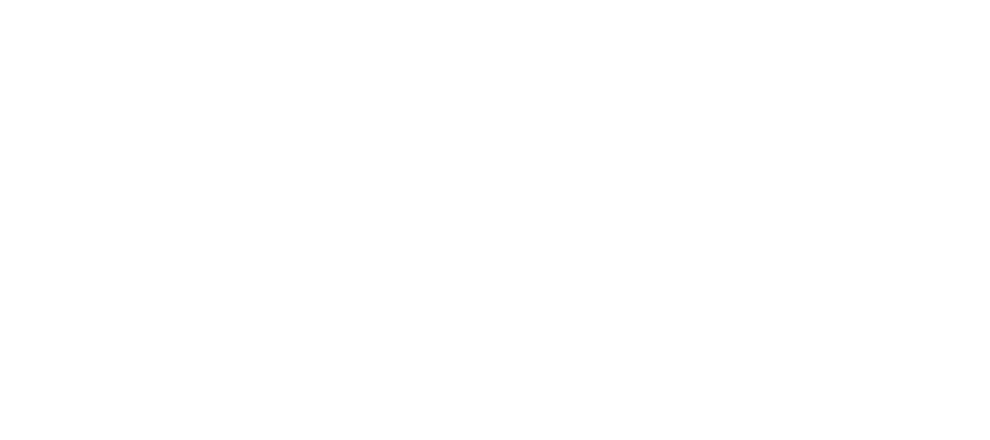

In [18]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191027-55B1N9_IV8K-204804.txt')

<IPython.core.display.Javascript object>


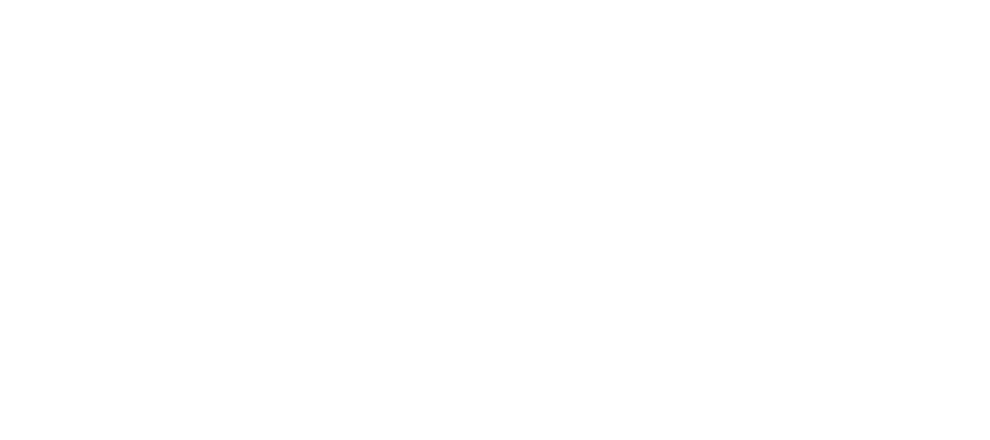

In [19]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191027-55B1N4_IV1K-234049.txt')

### Device #4

#### Measure N4 after condensation (not T_base yet)
- It shows pretty much IVc affected by noise either due to TASP or electronic noise from noisy source KE6220. (T8=300mK)

<IPython.core.display.Javascript object>


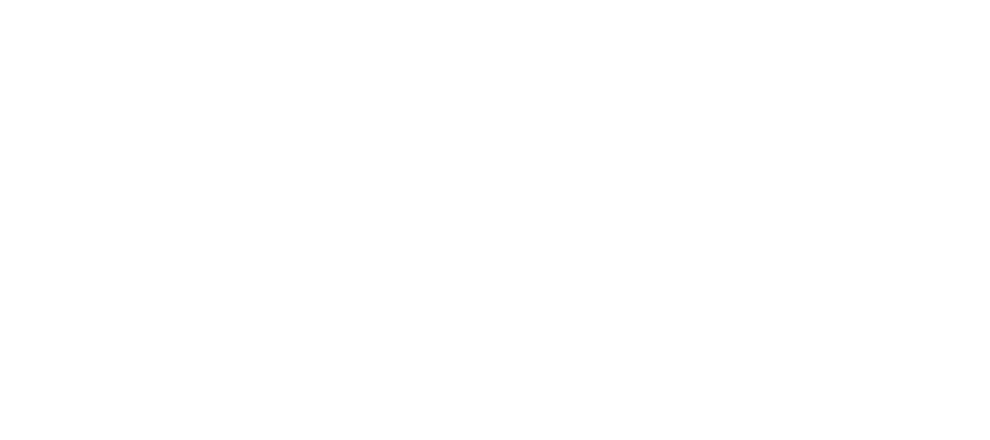

In [20]:
# Source: 6220
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191028-55B1N4_IV770mK-074618.txt')

#### Fixed the comm issue to AWG and be able to measure under DC biasing

<IPython.core.display.Javascript object>


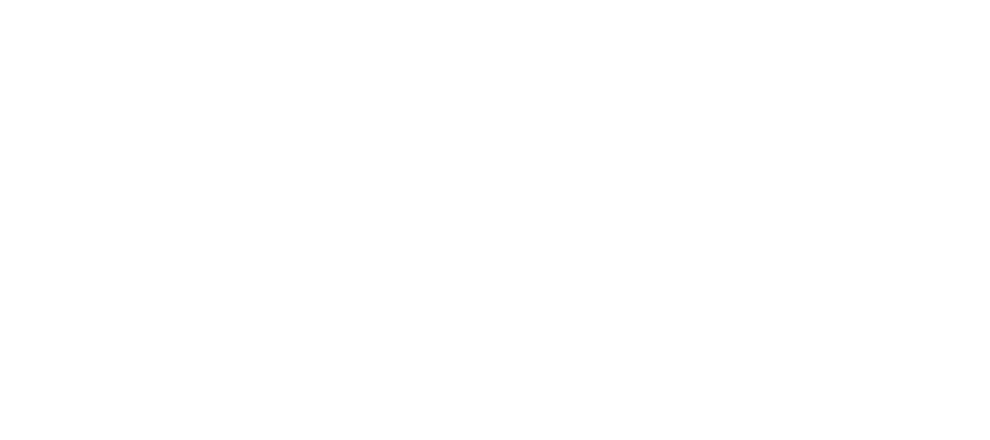

In [21]:
# Source: AWG
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191028-55B1N4_IV7K-164603.txt')

<IPython.core.display.Javascript object>


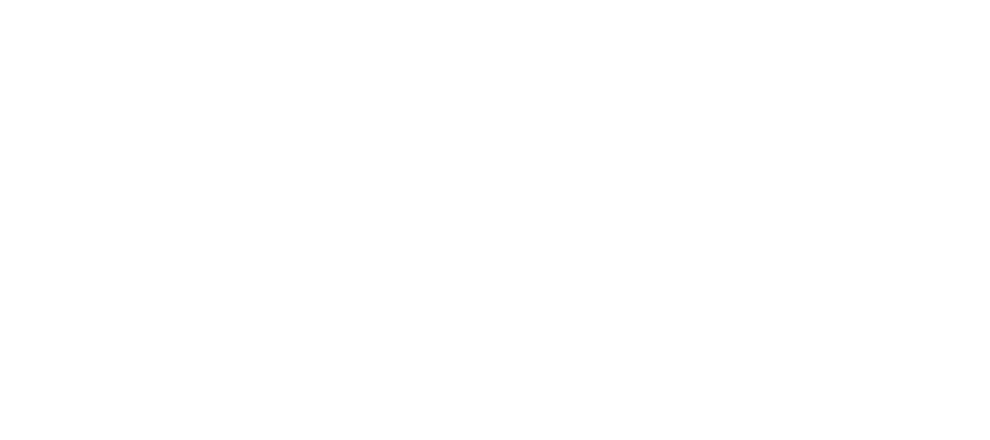

In [22]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191028-55B1N4_IVc-221448.txt')

<IPython.core.display.Javascript object>


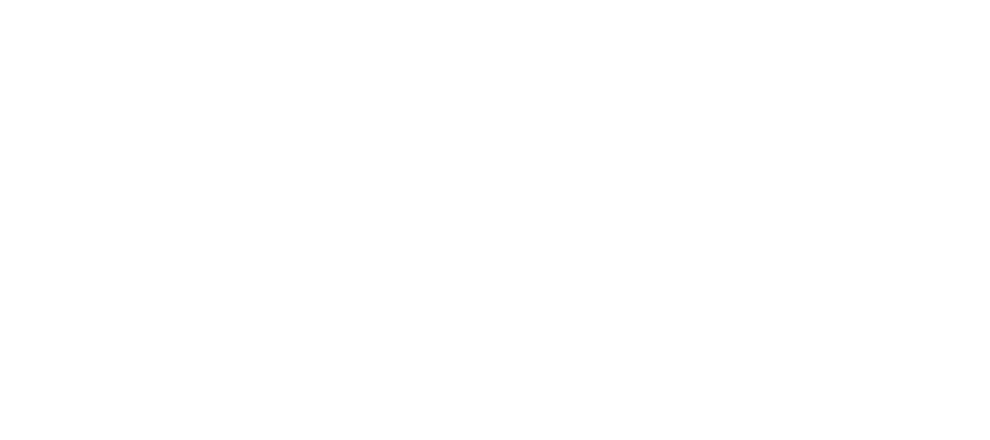

In [23]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-001206.txt')

<IPython.core.display.Javascript object>


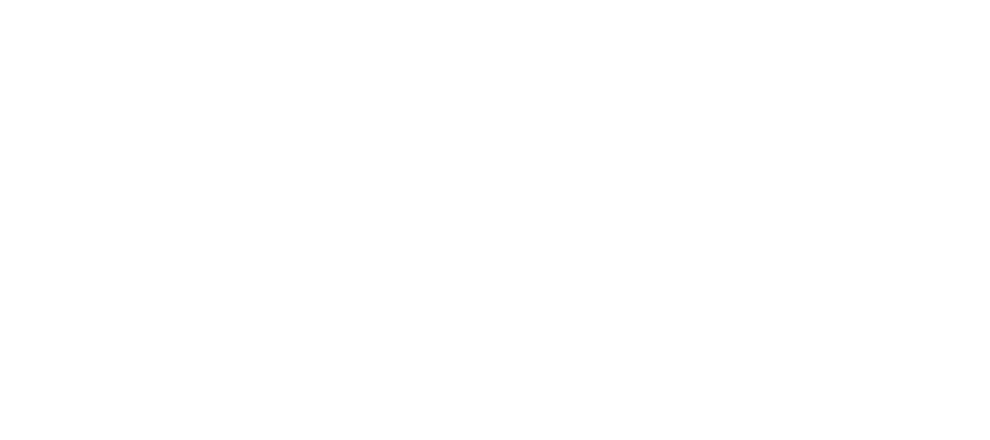

In [24]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-002204.txt')

<IPython.core.display.Javascript object>


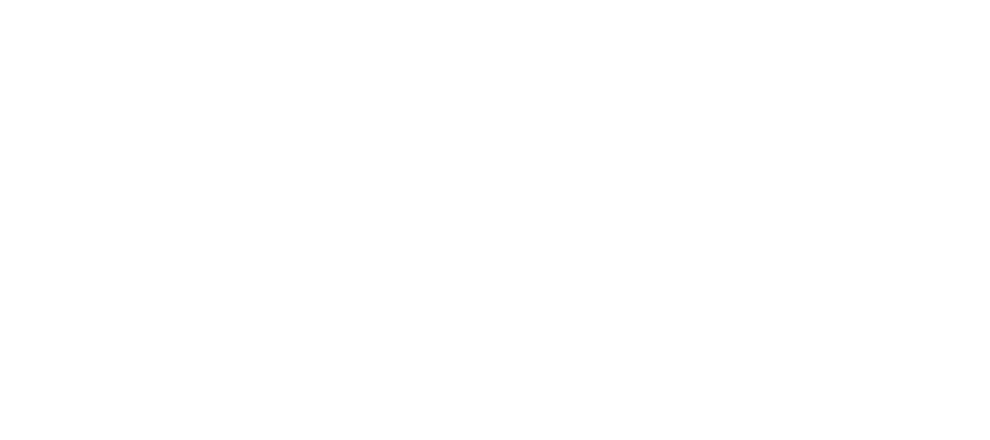

In [25]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-081827.txt')

>>> ***The data is quite unstable. We can even see the level wasn't at the same place.***

- check if preamp was saturated: No, during the whole process the preamp is ok
- try battery power
- check $R_{2pb}$: $180k\Omega$, $R_G = 13M\Omega$
- try 6220

<IPython.core.display.Javascript object>


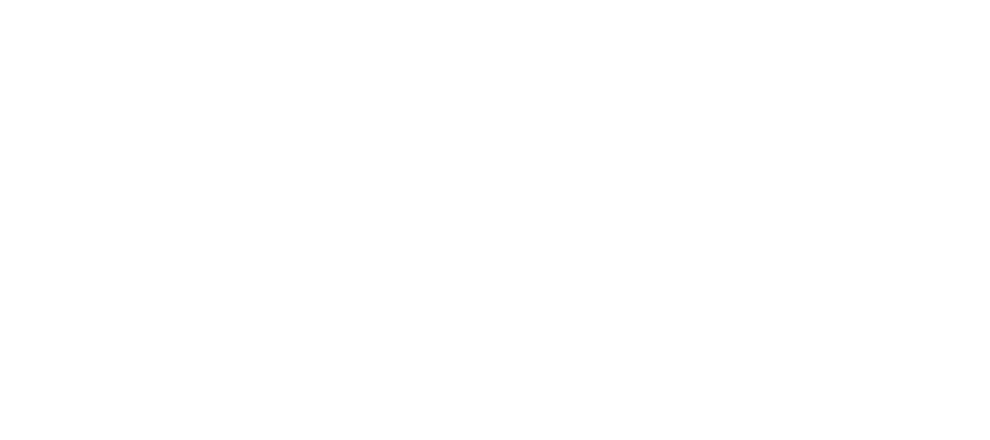

<IPython.core.display.Javascript object>


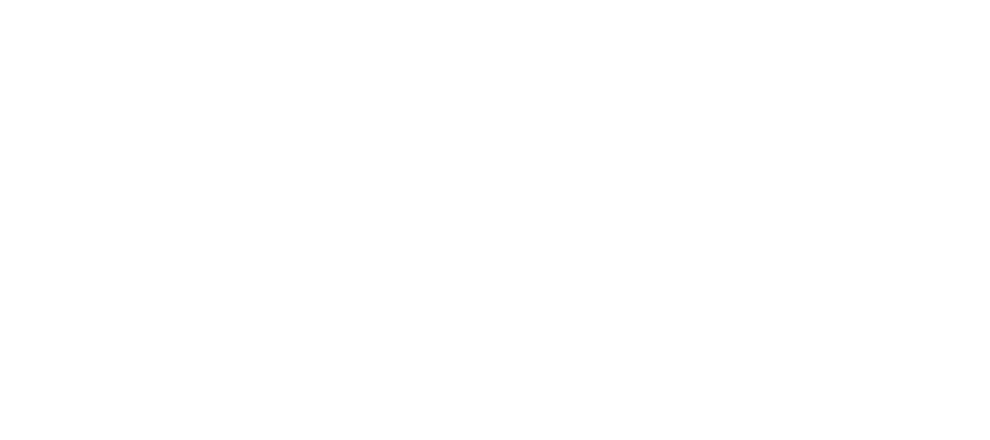

In [26]:
# double check after meas R2pb
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-095444.txt')
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-105933.txt')

<IPython.core.display.Javascript object>


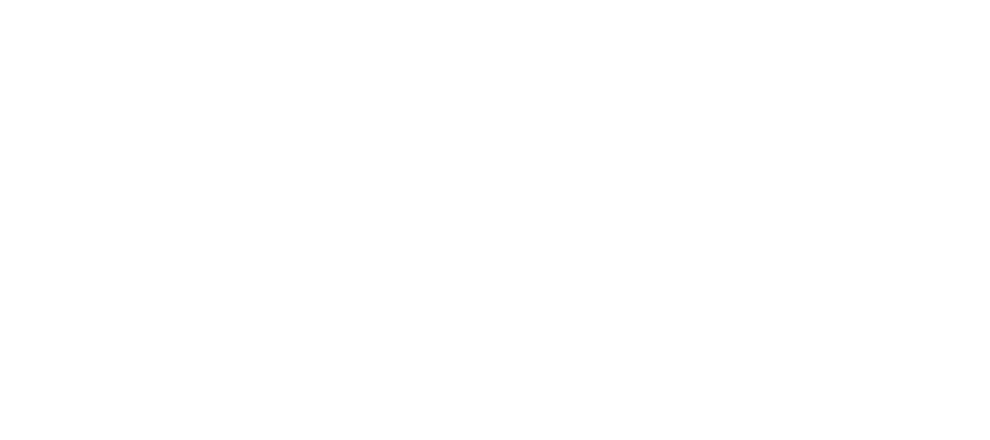

<IPython.core.display.Javascript object>


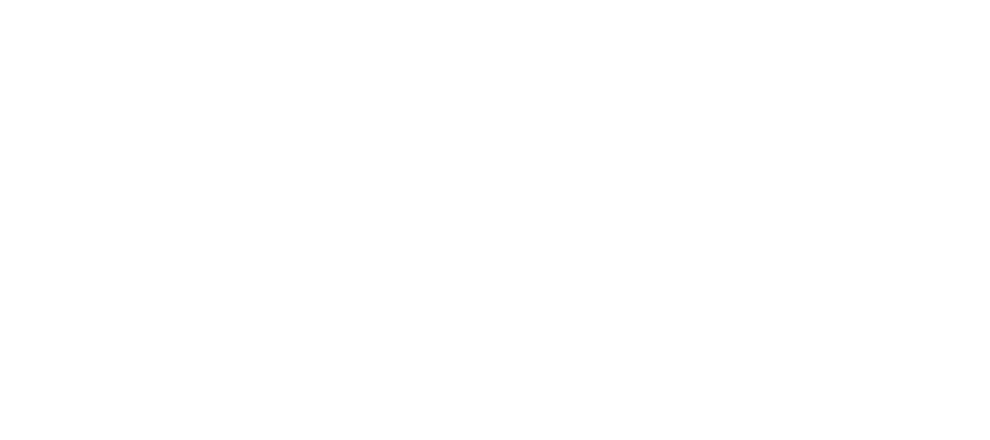

In [27]:
# Source: 6220
# The result took by 6220 seems to be more stable, while with greater noise.
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-101235.txt')
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191029-55B1N4_IVc-102121.txt')

#### Check the previous run 

<IPython.core.display.Javascript object>


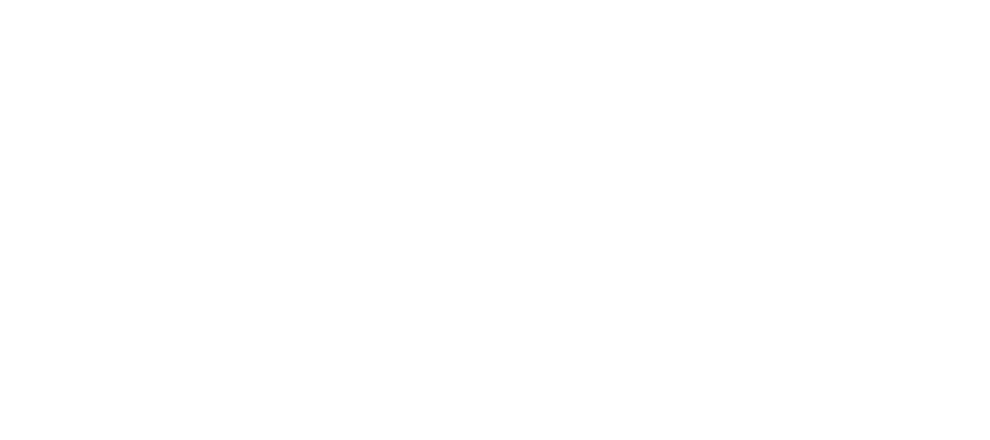

In [28]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\\191029-55B1N4_IVc-112415.txt')

<IPython.core.display.Javascript object>


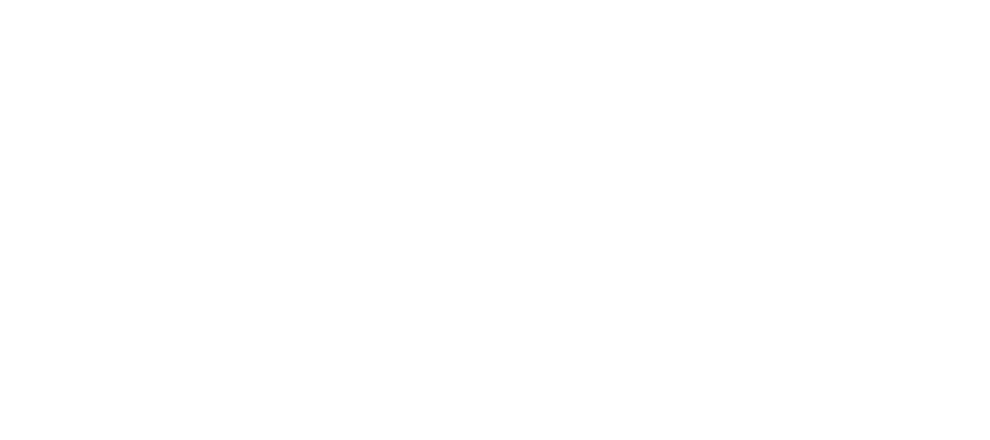

In [29]:
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\\191029-55B1N4_IVc-112415.txt')

<IPython.core.display.Javascript object>


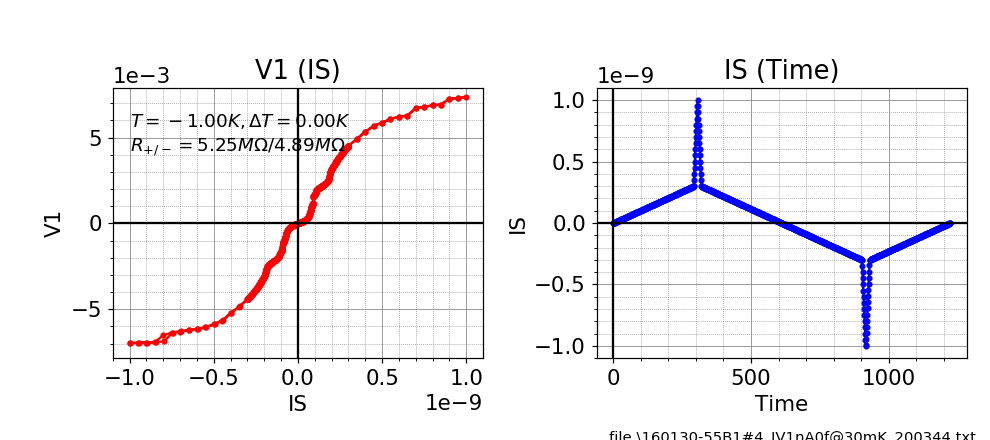

In [30]:
#Check the previous run
qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\160130-55B1#4_IV1nA0f@30mK_200344.txt')

# Qcode meas

In [31]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

In [32]:
K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.60s


In [33]:
LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.09s


In [34]:
SAMPLE = '55B1'

station = qc.Station(Isrc, Vmeter)
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)   
initialise_database()

In [35]:
def setup():
    Isrc.I.set(0) 

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [36]:
def IVC_udu (amp, stp, Gain, R_bias, Attn):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'udu IVC @T ={}K'.format(si_format(T8.get())) )  
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(0.025)
            V = Vmeter.V.get()

#             Vs.append(V)
            res = [( Isrc.I, i ), ( Vmeter.V, V )]
            datasaver.add_result(*res) 
        dataid = datasaver.run_id 

#     plot_by_id(dataid, marker = 'o', ls = '')  

In [37]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]

#     Vs = []
#     Is = []
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T ={}K'.format(si_format(T8.get())) )  
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(0.025)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
#                 print(dV)
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

#                 Is.append(i)
#                 Vs.append(V)
                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 
            dataid = datasaver.run_id 
#         plot_by_id(dataid, marker = 'o', ls = '')        
#         print(extract_Isw_R0_by_id (dataid))    

In [38]:
def extract_Isw_R0 (Is,Vs):
    
        Isw = (np.max(Is) - np.min(Is) ) /2
        
        order = Is.argsort()
        
        Is, Vs = Is[order], Vs[order]
        
        n = len(Is)
        n_min, n_max = np.int(n/3), np.int(2*n/3)
        
        print(n_min, n_max)
          
        n_sl = slice(n_min, n_max)
        
        R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))
        
        return Isw, R0

In [337]:
def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

Starting experimental run with id: 24


<IPython.core.display.Javascript object>


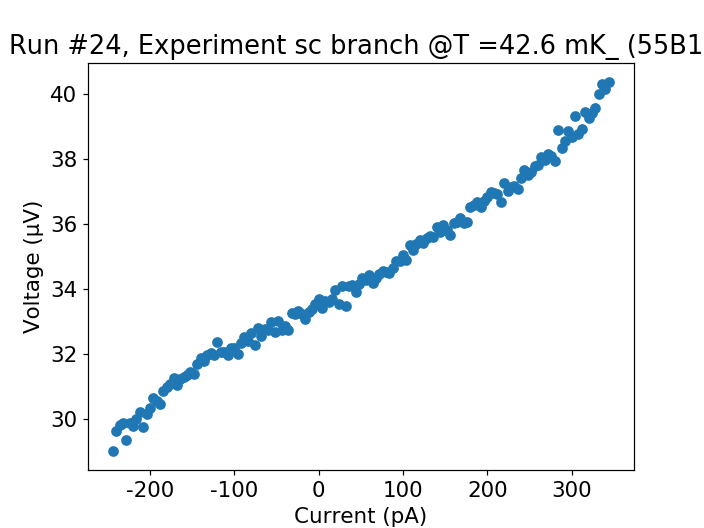

(2.98e-10, 19636.140939597306)

In [319]:
Ic_meas (amp = 1e-9, stp = 4e-12, thr = 2e-3, Gain = 100, R_bias = 1e9, Attn = 1)

Starting experimental run with id: 49


<IPython.core.display.Javascript object>


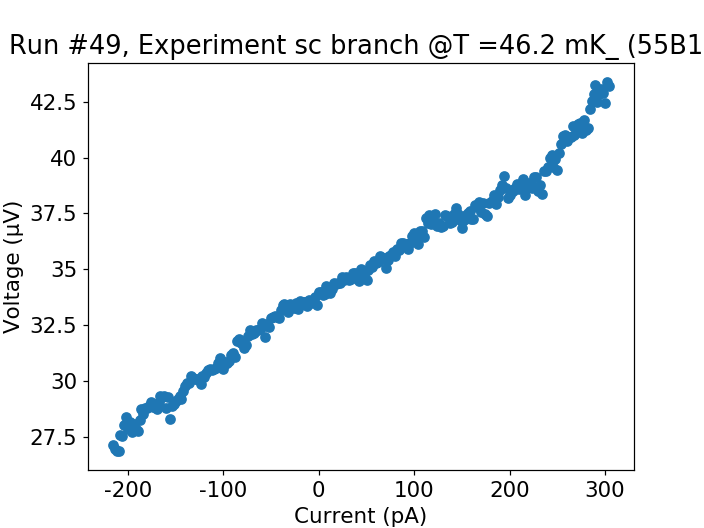

87 174
(2.6e-10, 23753.705882352937)


In [390]:
Flux_chA.step = .1e-3
Flux_chA.inter_delay = .1
Bfield.set(0e-3)
# sourcerange_i'

Ic_meas (amp = 1e-9, stp = 2e-12, thr = 1e-3, Gain = 100, R_bias = 1e9, Attn = 1)

In [520]:
amp = 1e-9
stp = 2e-12
thr = 1e-3

Vmeter.set_Gain (Gain = 100) 
Isrc.set_R_Attn (R_bias = 1e9, Attn=1)

i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
# ti_list_u = tqdm_notebook(i_list_u, leave = False)
i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)
# ti_list_d = tqdm_notebook(i_list_d, leave = False)
i_lists = [i_list_u ,  i_list_d]

# B_list =  np.linspace(0e-3, 2e-3, 51)
B_list =  np.linspace(1e-3, 2e-3, 11)
# B_list = [0.260E-3, 1.600E-3, 2.940E-3] #check periodicity
# for i in range(10): #check field stability
#     B_list.append(0.260E-3)
#     B_list.append(1.600E-3)

meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
tB_list = tqdm_notebook(B_list)
for B in tB_list:

    name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K,B={}A'.format(si_format(T8.get()), si_format(B, precision =3)) )  
    with meas.run() as datasaver:

        Bfield.set(B)
#         Is, Vs = [], []
        for i_list in i_lists:

            Isrc.I.set(0)
            V_ = Vmeter.V.get()
            time.sleep(1)

            for i in i_list:

                Isrc.I.set(i)
                time.sleep(0.025)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V

                if  (abs(V) > 8e-3) : #(abs(dV) > thr)  or 
                    break

                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 

#                 Is.append(i)
#                 Vs.append(V)
#         Is, Vs = np.array(Is), np.array(Vs) 
#         print(extract_Isw_R0 (Is, Vs))

        dataid = datasaver.run_id 
#         plot_by_id(dataid)•

Starting experimental run with id: 422
Starting experimental run with id: 423
Starting experimental run with id: 424
Starting experimental run with id: 425
Starting experimental run with id: 426
Starting experimental run with id: 427
Starting experimental run with id: 428
Starting experimental run with id: 429
Starting experimental run with id: 430
Starting experimental run with id: 431
Starting experimental run with id: 432



In [521]:
amp = 1e-9
stp = 2e-12
thr = 1e-3

Vmeter.set_Gain (Gain = 100) 
Isrc.set_R_Attn (R_bias = 1e9, Attn=1)

i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
# ti_list_u = tqdm_notebook(i_list_u, leave = False)
i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)
# ti_list_d = tqdm_notebook(i_list_d, leave = False)
i_lists = [i_list_u ,  i_list_d]

B_list =  np.linspace(0e-3, 2e-3, 51)
# B_list =  np.linspace(1e-3, 2e-3, 11)
# B_list = [0.260E-3, 1.600E-3, 2.980E-3]

meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
tB_list = tqdm_notebook(B_list)
for B in tB_list:

    name_exp(sample = SAMPLE, exp_type = 'IVc(B) @T={}K,B={}A'.format(si_format(T8.get()), si_format(B, precision =3)) )  
    with meas.run() as datasaver:

        Bfield.set(B)
#         Is, Vs = [], []
        for i_list in i_lists:

            Isrc.I.set(0)
            V_ = Vmeter.V.get()
            time.sleep(1)

            for i in i_list:

                Isrc.I.set(i)
                time.sleep(0.025)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V

                if  (abs(dV) > thr)  or (abs(V) > 4e-3) : #(abs(dV) > thr)  or 
                    break

                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 

#                 Is.append(i)
#                 Vs.append(V)
#         Is, Vs = np.array(Is), np.array(Vs) 
#         print(extract_Isw_R0 (Is, Vs))

        dataid = datasaver.run_id 
#         plot_by_id(dataid)•

Starting experimental run with id: 433
Starting experimental run with id: 434
Starting experimental run with id: 435
Starting experimental run with id: 436
Starting experimental run with id: 437
Starting experimental run with id: 438
Starting experimental run with id: 439
Starting experimental run with id: 440
Starting experimental run with id: 441
Starting experimental run with id: 442
Starting experimental run with id: 443
Starting experimental run with id: 444
Starting experimental run with id: 445
Starting experimental run with id: 446
Starting experimental run with id: 447
Starting experimental run with id: 448
Starting experimental run with id: 449
Starting experimental run with id: 450
Starting experimental run with id: 451
Starting experimental run with id: 452
Starting experimental run with id: 453
Starting experimental run with id: 454
Starting experimental run with id: 455
Starting experimental run with id: 456
Starting experimental run with id: 457
Starting experimental run

In [40]:
from qcodes.dataset.data_set import load_by_id
def labelledplot (run_id, ax, str1, str2):
    dataset = load_by_id(run_id)
    stri = dataset.exp_name.split(str1)[1]
    stri = stri.split(str2)[0]
    plot_by_id(run_id, ax, marker = '.', ls = '-', label=stri)

**The SQUID loop periodicity is about (1.60-0.22)mA**

<IPython.core.display.Javascript object>


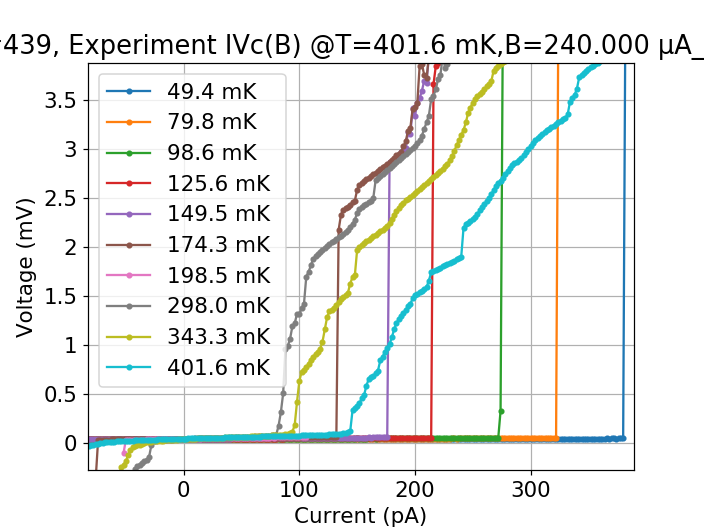

In [41]:
fig, ax = plt.subplots()
for i in [184,229,231]:
    labelledplot (i, ax, 'T =', ',')
for i in [233,236,238,252,312,357,439]:
    labelledplot (i, ax, 'T=', ',')
    
ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=2)
ax.grid('both')

<IPython.core.display.Javascript object>


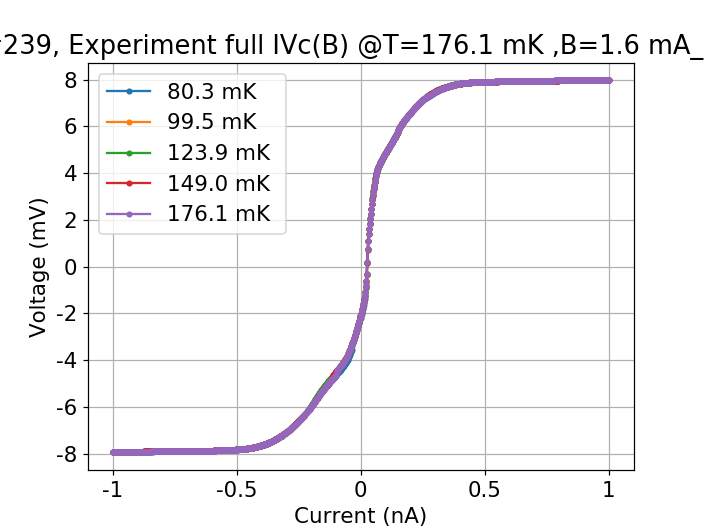

In [532]:
fig, ax = plt.subplots()
for i in [230,232]:
    labelledplot (i, ax, 'T =', ',')
for i in [234,237,239]:
    labelledplot (i, ax, 'T=', ',')
    
ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=2)
ax.grid('both')

<IPython.core.display.Javascript object>


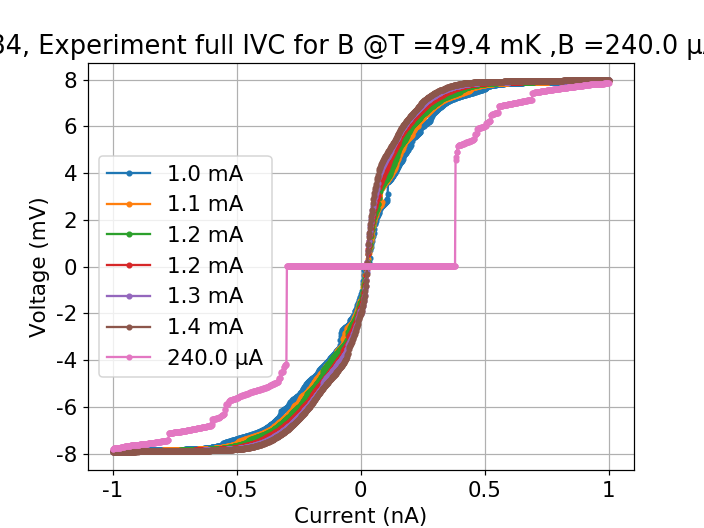

In [533]:
fig, ax = plt.subplots()
for i in range(6):
    labelledplot (2*i+203, ax, 'B =', '_')
labelledplot (184, ax, 'B =', '_')

ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


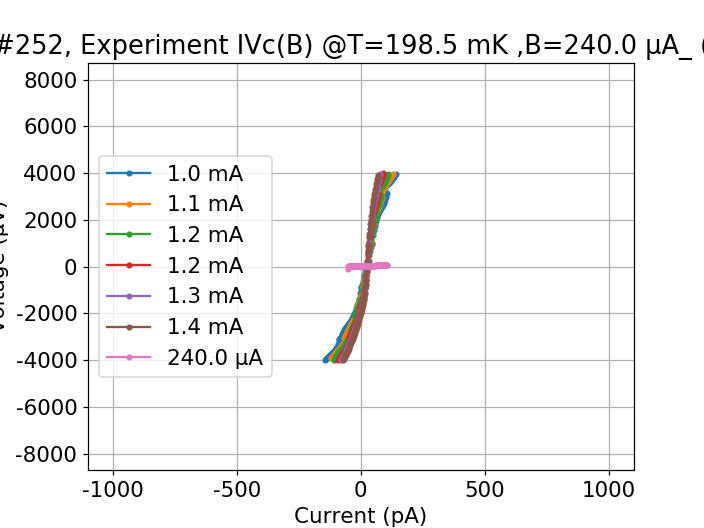

In [534]:
fig, ax = plt.subplots()
for i in range(6):
    labelledplot (2*i+272, ax, 'B=', '_')
labelledplot (252, ax, 'B=', '_')

ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


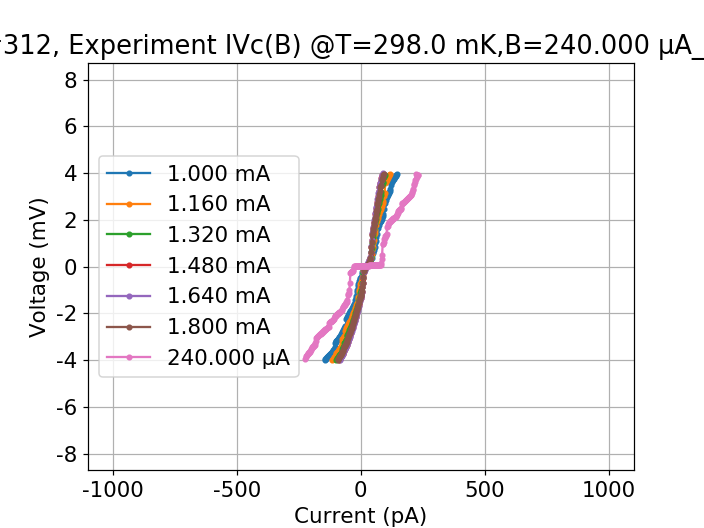

In [535]:
fig, ax = plt.subplots()
for i in range(6):
    labelledplot (4*i+331, ax, 'B=', '_')
labelledplot (312, ax, 'B=', '_')

ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


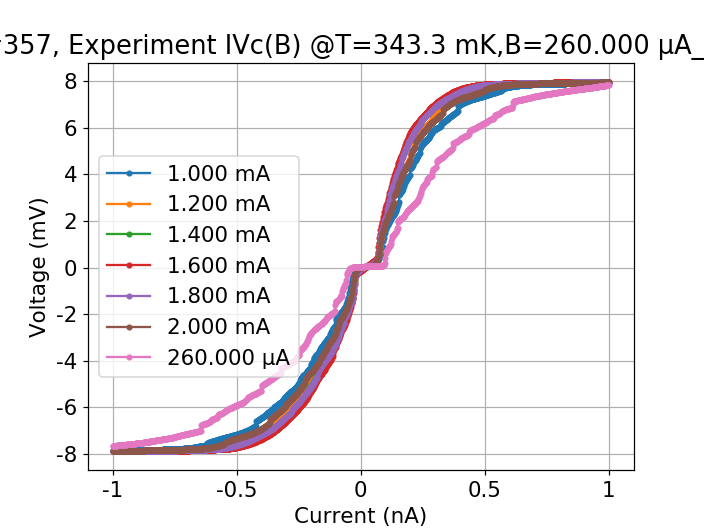

In [536]:
fig, ax = plt.subplots()
for i in range(6):
    labelledplot (1*i+416, ax, 'B=', '_')
labelledplot (357, ax, 'B=', '_')
    
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


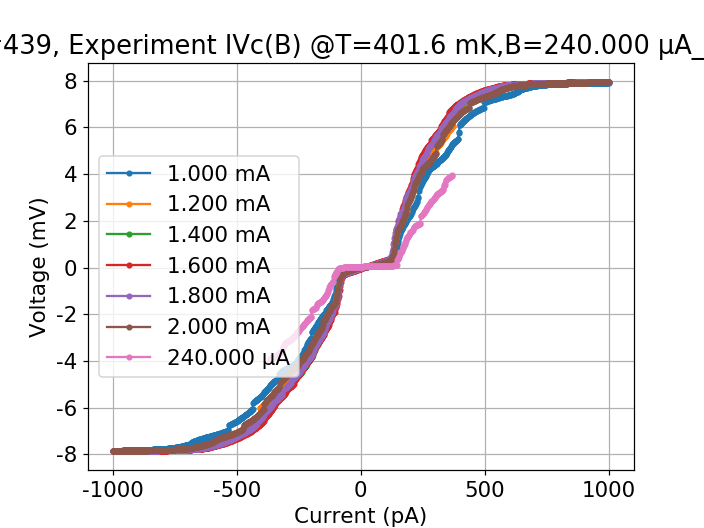

In [537]:
fig, ax = plt.subplots()
for i in range(6):
    labelledplot (2*i+422, ax, 'B=', '_')
labelledplot (439, ax, 'B=', '_')
    
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


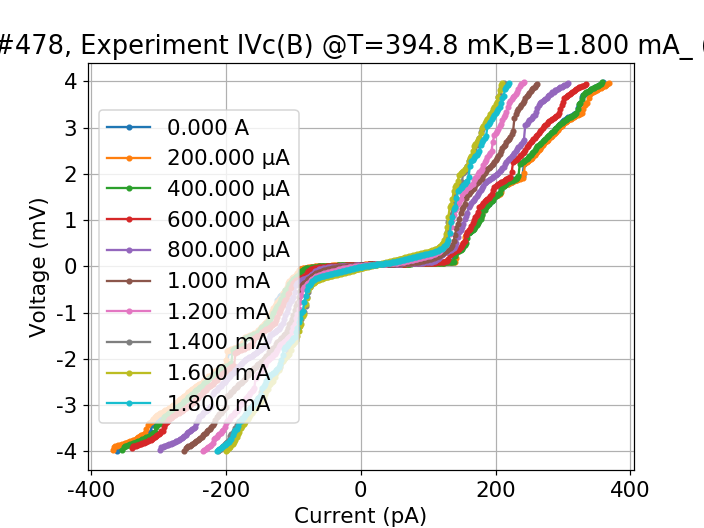

In [538]:
fig, ax = plt.subplots()
for i in range(10):
    labelledplot (5*i+433, ax, 'B=', '_')
    
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


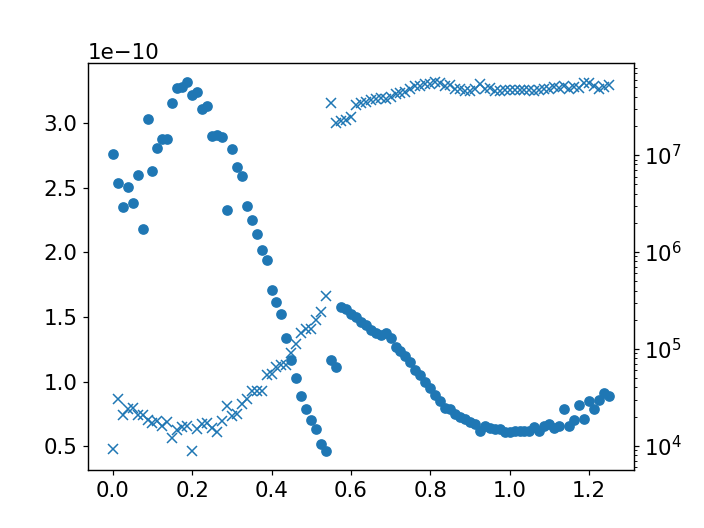

In [455]:
fig, ax = plt.subplots()

phase = np.pi*B_list/3.2e-3/np.pi*2
# cos = abs(np.cos(phase) )
ax.plot(phase, Isws, 'o')
# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(phase, R0s, 'x')
ax2.set_yscale('log')

<IPython.core.display.Javascript object>


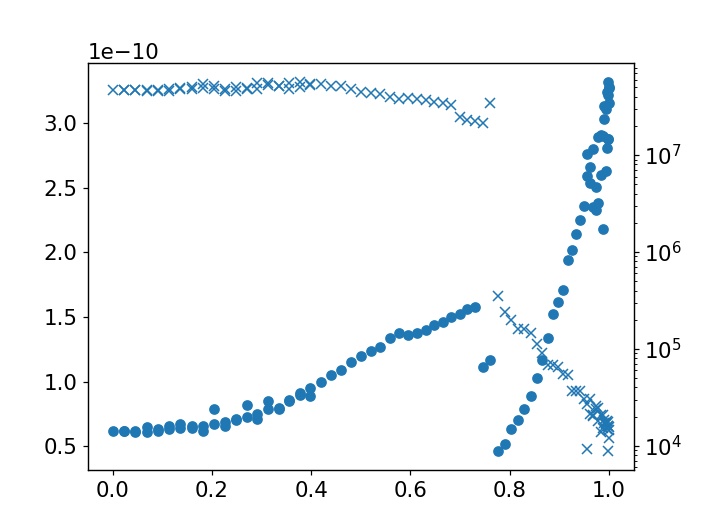

In [466]:
fig, ax = plt.subplots()


cos = abs(np.cos(np.pi*(B_list-.26e-3)/2.76e-3) )
ax.plot(cos, Isws, 'o')

# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(cos, R0s, 'x')
ax2.set_yscale('log')


In [335]:
alldata = get_data_by_id(24)

Is = alldata[0][0]['data']
Vs = alldata[0][1]['data']
Isw = (np.max(Is) - np.min(Is) ) /2

extract_Isw_R0 (Is,Vs)

50 100


(2.98e-10, 16742.864583333318)

In [367]:
extract_Isw_R0_by_id (36)

16 32


(2.2999999999999998e-10, 30902.000000000033)

Starting experimental run with id: 16



<IPython.core.display.Javascript object>


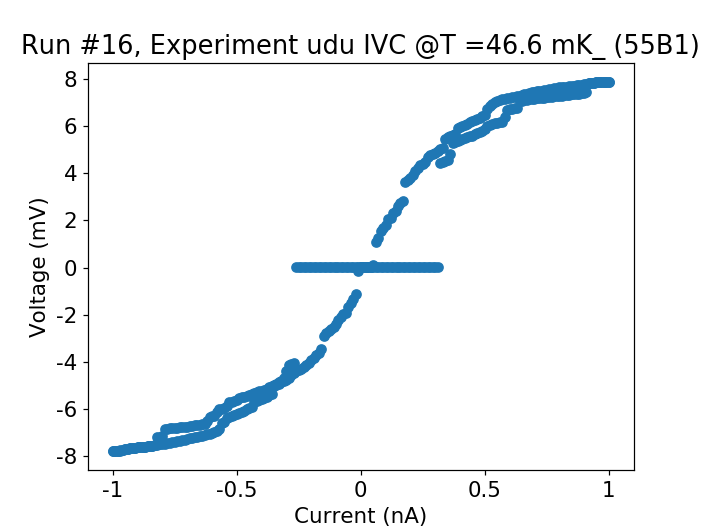

In [295]:
IVC_udu (amp = 1e-9, stp = 10e-12, Gain = 100, R_bias = 1e9, Attn = 1)

Starting experimental run with id: 15



<IPython.core.display.Javascript object>


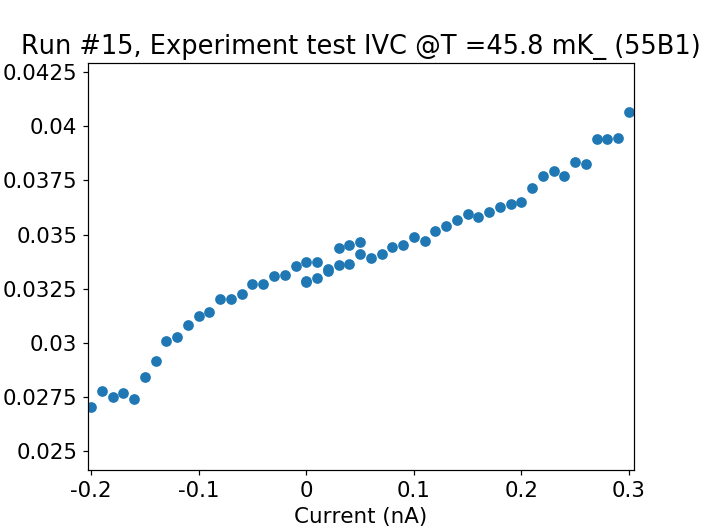

([<matplotlib.axes._subplots.AxesSubplot at 0xcdd8090>], [None])

In [271]:
meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

i_list = np.linspace(-0e-9, 1e-9, 251)
i_list = udu_list(1e-9, 10e-12)
ti_list = tqdm_notebook(i_list)

# Vs = []

name_exp(sample = SAMPLE, exp_type = 'test IVC @T ={}K'.format(si_format(T8.get())) )  
with meas.run() as datasaver:
    
    for i in ti_list:
        Isrc.I.set(i)
        time.sleep(0.025)
        
        V = Vmeter.V.get()
        
        res = [( Isrc.I, i ), ( Vmeter.V, V )]
#         Vs.append(V)
        datasaver.add_result(*res) 
     
    dataid = datasaver.run_id 
    
plot_by_id(dataid, marker = 'o', ls = '')

In [105]:
dataset.get_parameter_data(Isrc_I)

NameError: name 'Isrc_I' is not defined

**continue working by WS.**
- It seems that the plot_by_id function somehow plot the data in a straight line instead of time-sequenced.
- ToDo:
    - Record if attenuation can reduce the noise / enhance Ic
    - Record if AWG5204 has reduced noise.
    - Need to incorporate Gain in HP34401

In [234]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

In [235]:
meter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain=100)
#meter.init('fast 6')
print(meter.V.get())

3.2908210000000005e-05


In [215]:
def plotbyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
#     x = ['alldata'][0][0]['data']
#     y = ['alldata'][0][1]['data']

    return ({'title':title, 'alldata':alldata})

In [384]:
print(plotbyid(48)['alldata'][0][2]['data'])

[3.419316e-05 3.441364e-05 3.486984e-05 ...          nan          nan
          nan]


In [389]:
print(plotbyid(48)['alldata'][0][0]['name'])

K2602_smua_curr


<IPython.core.display.Javascript object>


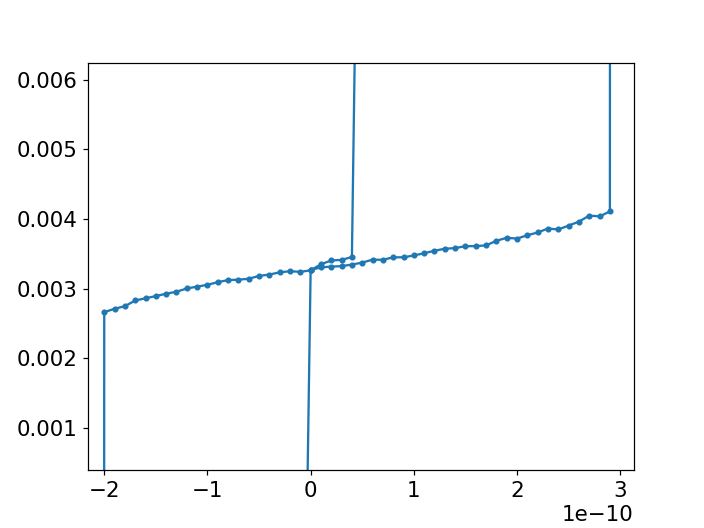

In [236]:
fig, ax = plt.subplots()
ax.plot(alldata[0][0]['data'], alldata[0][1]['data'], '.-')